<a href="https://colab.research.google.com/github/stefanocostantini/pytorch-book/blob/master/ch8_using_convolutions_to_generalise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

We re-create the same datasets which we used in the previous chapter

In [2]:
import torch
from torchvision import transforms

In [3]:
## Download files locally
!mkdir /content/cifar10/
from torchvision import datasets
data_path_for_saving = '/content/cifar10/'
cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=True)

Extracting /content/cifar10/cifar-10-python.tar.gz to /content/cifar10/
Files already downloaded and verified


In [4]:
tensor_cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=False,
                                  transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=False,
                                      transform=transforms.ToTensor())

In [5]:
imgs = torch.stack([item_t for item_t, _ in tensor_cifar10], dim = 3)
reshaped = imgs.view(3,-1) # keep the first dimension, squash all others into a single dim
print(reshaped.shape)

means = reshaped.mean(dim=1) # mean of the first dimension (i.e. the three channels)
stds = reshaped.std(dim=1)


torch.Size([3, 51200000])


In [6]:
# Now we have the information to do the normalisation, as follows.
# Note that we `compose` transformations together
transformed_cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((means[0], means[1], means[2]),
                                                              (stds[0], stds[1], stds[2]))                              
                                       ]))

transformed_cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=False,
                                       transform = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((means[0], means[1], means[2]),
                                                              (stds[0], stds[1], stds[2]))                              
                                       ]))

In [7]:
# We just want to keep class 0 and 2. Remember that the __getitem__ method returns
# both the item and its label
class_mapping = {0: 0, 2: 1}

cifar2 = [(item, class_mapping[label])
          for item, label in tensor_cifar10 if label in [0,2]]
cifar2_val = [(item, class_mapping[label])
          for item, label in tensor_cifar10_val if label in [0,2]] 

## Intro to convolutions

_**Note:** We now have the same datasets as before (`cifar2` and `cifar2_val`) at our disposal._

_**Note 2:** my focus for this chapter is on how to subclass the `nn` module, hence will cover convolutions only at a high level._

Convolutions are needed to deliver locality and translation invariance.

Convolutions for a 2D image are the scalar (dot) product of a weight matrix (the _kernel_) with every neighbourhood in the input.

So, if we have kernel as follows:

```
weight = torch.tensor([[w00, w01, w02],
                       [w10, w11, w12],
                       [w20, w21, w22]])
```
and  a 1-channel MxN image:
```
image = torch.tensor([[i00, i01, i02, i03, ..., i0N],
                      [i10, i11, i12, i13, ..., i1N],
                      [i20, i21, i22, i23, ..., i2N],
                      [i30, i31, i32, i33, ..., i3N],
                      ...
                      [iM0, iM1m iM2, iM3, ..., iMN]])
```
The the output at, say, `1,1` can be calculated as follows (without bias):
```
o11 = i11 * w00 + i12 * w01 + i13 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22
```
By repeating this calculation for each input of the image (i.e. by translating the kernel on all input locations) we obtain an output image where each location will be expressed as a weighted sum of its immediate vicinity (depending on the size of the kernel).

Note that we do not know the weights in advance: these are randomly initialised at the beginning and then learned through model training. Note also that the same weights are using across the whole image, so they have a history spanning the entire image. Thus, the derivative of the loss with respect to a convolution weight includes contributions from the entire image.

This also mean that we have many fewer parameters compared with a fully connected model which accepts 1D inputs. The number of parameters will no longer depend on the number of pixels in the image, but rather on:
- the size of the convolution kernel
- how many convolution filters (or output channels) there are

## Using convolutions

The `torch.nn` module provides convolutions for 1, 2 and 3 dimensions: `nn.Conv1D` for time series (and text), `nn.Conv2D` for images and `nn.Conv3D` for volumes or video. 

To `nn.Conv2D` we need to provide the following arguments:
- the number of input features (or channels, as there will be more than 1 value per pixel)
- the number of output features
- the size of the kernel.

In [9]:
from torch import nn

In [21]:
# In our case we have 3 channels, so the input features will be 3. We choose an
# arbitrary output of 16 features and a 3x3 kernel
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [23]:
# And these are the dimensions of weight and bias
conv.weight.shape, conv.bias.shape
# 16 output features, 3 input features (channel) and a 3x3 kernel. 

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [25]:
# Let's apply the convolution to one of the images in the dataset and compare it
# with the original one. Let's get the image first:
img, _ = cifar2[0]

# Need to add the zero-th batch dimension
output = conv(img.unsqueeze(0))

# Let's check the dimensions - it looks like we've lost 2 pixels from each dimension...
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

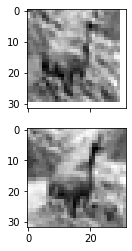

In [45]:
# Displaying the two images reveals what has happened:
from matplotlib import pyplot as plt 
f, axarr = plt.subplots(2, sharex=True, sharey=True)
axarr[0].imshow(output[0,0].detach(), cmap='gray')
axarr[1].imshow(img[0].detach(), cmap='gray')
plt.show()

In [46]:
# We can prevent this from happening by having some padding, which uses `ghost` pixels
# on the sides of the image.
conv_padded = nn.Conv2d(3,16, kernel_size=3, padding=1)
output_padded = conv_padded(img.unsqueeze(0))
img.unsqueeze(0).shape, output_padded.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

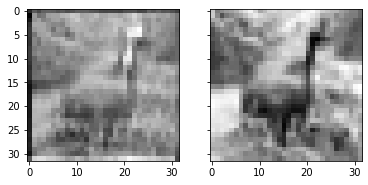

In [59]:
f, axarr = plt.subplots(1,2, sharex=True, sharey=True)
axarr[0].imshow(output_padded[0,0].detach(), cmap='gray')
axarr[1].imshow(img[0].detach(), cmap='gray')
plt.show()

A way to make sure the convolutions can really pick up the salient features of an image, is to put these through some downsampling, so that only the "strongest" features, i.e. the features that better characterise an image would survive.

This is achieved by using a `max pooling` operation, where only the features with the maximum value in an area are kept. This reduces the size of the image, keeping only the most salient features. 

Let's apply this to our image and see what we get.

In [50]:
max_pool = nn.MaxPool2d(2) # using 2 halves the size of the image
output_pool = max_pool(output_padded)
output_padded.shape, output_pool.shape
# We can see the size has been halve. And we can display all three images

(torch.Size([1, 16, 32, 32]), torch.Size([1, 16, 16, 16]))

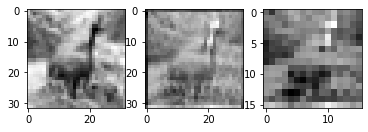

In [58]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img[0].detach(), cmap='gray')
axarr[1].imshow(output_padded[0,0].detach(), cmap='gray')
axarr[2].imshow(output_pool[0,0].detach(), cmap='gray')
plt.show()
# Note that the last image is half the size of the other two (much more "pixelated"), 
# but also note that compared to the output of the convolution, it appears 
# to give more weight to certain aspects of the image.

## Putting everything together in a model

We can now put the elements we have into a single model

In [66]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2), # reducing the image size by half
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2), # we now have a 8x8 image
#   nn.Flatten(), # not used to motivate the subclassing of nn.Module - see below
    nn.Linear(8 * 8 * 8, 32), # 8 channels from previous convolution, 8x8 image from MaxPool
    nn.Tanh(),
    nn.Linear(32,2)) # output of dimension 2, the class probabilities

# Note that at some point, we need to go from a 2D tensor to a 1D one.

In [67]:
# What happens if we try to get an output from this?
out = model(img.unsqueeze(0))
out

RuntimeError: ignored

This is due to the fact that we're not reshaping from a 8-channel 8x8 image to a 512-element 1D vector. We could do it with `view`, but in this case within the `nn.Sequential` module, we don't see the output of the previous model, so we can't use `view`.

Let's use this as an opportunity to show that we can write our own module, which will enable us to do this reshaping. We do this by subclassing `nn.Module`. 

_(**Note:** since version 1.3 pytorch has the module `nn.Flatten()` which would solve this problem, but we go ahead with the alternative appraoch anyway)_

In [10]:
# We define all modules in the class, and then put them together in the `forward`
# method. Note that there is no `backward` method, as pytorch uses autograd.

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv1(out)))
    out = out.view(-1, 8 * 8 * 8) # the reshaping we needed before
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return(out)


In [72]:
# We can also see how big (i.e. how many parameters this model has)
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Note that here we're using the model to define the entire network, but it could also be defined to a building block that could be used as a model within `nn.Sequential`

Now, there is a way to write the above model in a more compact way, avoiding having to write out the module that have no parameters, like `nn.Tanh` and `nn.MaxPool2D`. For that we can use their functional form.

In [11]:
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8) # the reshaping we needed before
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return(out)


We can now train the model as usual. We will need to first write a training loop

In [12]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      outputs = model(imgs) # calculate predictions
      loss = loss_fn(outputs, labels) # calculate loss
      optimizer.zero_grad() # get rid of the previous gradient
      loss.backward() # backprop
      optimizer.step() # update parameters
      loss_train += loss.item()
    
    if epoch ==1 or epoch % 10 == 0:
      print(f'{datetime.datetime.now()} - Epoch: {epoch} - Loss: {loss_train / len(train_loader)}') # average loss per batch

In [13]:
# And finally we can train. Running on CPU this will take a while
import torch.utils.data
import torch.optim as optim

In [14]:
# Define the loader
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [15]:
# Initialise the model, definte optimizer and the loss
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [88]:
# Train
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2020-08-14 16:34:59.480955 - Epoch: 1 - Loss: 0.6714251307165546
2020-08-14 16:35:39.461101 - Epoch: 10 - Loss: 0.4660154134984229
2020-08-14 16:36:23.742914 - Epoch: 20 - Loss: 0.35437491279878436
2020-08-14 16:37:07.903650 - Epoch: 30 - Loss: 0.33049961886588175
2020-08-14 16:37:52.014473 - Epoch: 40 - Loss: 0.3133844162817973
2020-08-14 16:38:36.654306 - Epoch: 50 - Loss: 0.30199066744108866
2020-08-14 16:39:20.821056 - Epoch: 60 - Loss: 0.29209849295342805
2020-08-14 16:40:05.448901 - Epoch: 70 - Loss: 0.27837342612302984
2020-08-14 16:40:50.029361 - Epoch: 80 - Loss: 0.26692975772793887
2020-08-14 16:41:34.388436 - Epoch: 90 - Loss: 0.2520826905491246
2020-08-14 16:42:18.656572 - Epoch: 100 - Loss: 0.24048625170045598


Let's now check the model accuracy

In [89]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [90]:
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    
    with torch.no_grad():
      for imgs, labels in loader:
        outputs = model(imgs)
        _ , predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print(f"Accuracy: {name, correct / total}")      

In [91]:
validate(model, train_loader, val_loader)

Accuracy: ('train', 0.8992)
Accuracy: ('val', 0.879)


Finally we can see how to save and load the model

In [25]:
# saving the model
!mkdir "/content/models"
path = '/content/models/'
torch.save(model.state_dict(), path + 'birds_vs_airplanes.pt')

In [93]:
# loading the model
loaded_model = Net() # to load the model, you first need to initialise it with
                     # exactly the same definition!

loaded_model.load_state_dict(torch.load(path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

## Training on the GPU

We can now train the model on the GPU to make it faster. First let's check that the GPU is indeed available

In [16]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Training on device {device}')

Training on device cuda


To train on the GPU we need to move our tensors there using the `Tensor.to` method. So our training loop changes as follows:

In [18]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  print(device)
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs) # calculate predictions
      loss = loss_fn(outputs, labels) # calculate loss
      optimizer.zero_grad() # get rid of the previous gradient
      loss.backward() # backprop
      optimizer.step() # update parameters
      loss_train += loss.item()
    
    if epoch ==1 or epoch % 10 == 0:
      print(f'{datetime.datetime.now()} - Epoch: {epoch} - Loss: {loss_train / len(train_loader)}') # average loss per batch

Apart from that change, everything stays the same. So let's train again, and see how much faster it goes.

In [19]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device) # Need to move the model to the GPU as well
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

cuda
2020-08-14 17:43:43.428740 - Epoch: 1 - Loss: 0.6838089284623504
2020-08-14 17:43:46.942467 - Epoch: 10 - Loss: 0.4714757557127886
2020-08-14 17:43:50.869793 - Epoch: 20 - Loss: 0.36084253298249214
2020-08-14 17:43:54.835164 - Epoch: 30 - Loss: 0.32321396299228544
2020-08-14 17:43:58.794928 - Epoch: 40 - Loss: 0.30528587368643206
2020-08-14 17:44:02.727775 - Epoch: 50 - Loss: 0.2913887944001301
2020-08-14 17:44:06.689945 - Epoch: 60 - Loss: 0.2774290480431478
2020-08-14 17:44:10.603068 - Epoch: 70 - Loss: 0.26580145784244413
2020-08-14 17:44:14.528947 - Epoch: 80 - Loss: 0.2524760164273013
2020-08-14 17:44:18.481933 - Epoch: 90 - Loss: 0.23991774914750627
2020-08-14 17:44:22.447318 - Epoch: 100 - Loss: 0.23043173921715682


And we will need to make the same changes to validate the model

In [20]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [21]:
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    
    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        model = model.to(device=device)
        outputs = model(imgs)
        _ , predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print(f"Accuracy: {name, correct / total}")    

In [22]:
validate(model, train_loader, val_loader)

Accuracy: ('train', 0.9089)
Accuracy: ('val', 0.881)


Finally, there is a **complication** when loading network weights: pytorch will attempt to load the weights to the save device it was saved from. We have 2 options:
1. move the model to the CPU before saving
2. tell pytorch to override the device info when loading weights, as follows:

In [26]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

## Model design